In [262]:
import numpy as np
from collections import defaultdict

# Dataset

In [263]:
data_path = 'File//ratings.dat'

In [264]:
n_users = 6040
n_movies = 3706

In [265]:
def load_rating_data(data_path, n_users, n_movies):
    """
    Load rating data from file and also return the number of ratings for each movie and movie_id index mapping
    @param data_path: path of the rating data file
    @param n_users: number of users
    @param n_movies: number of movies that have ratings
    @return: rating data in the numpy array of [user, movie]; movie_n_rating, {movie_id: number of ratings};
             movie_id_mapping, {movie_id: column index in rating data}
    """
    data = np.zeros([n_users, n_movies], dtype=np.float32)
    movie_id_mapping = {}
    movie_n_rating = defaultdict(int)
    with open(data_path, 'r') as file:
        for line in file.readlines()[1:]:
            try:
                user_id, movie_id, rating, _ = line.split("::")
                user_id = int(user_id) - 1
                if movie_id not in movie_id_mapping:
                    movie_id_mapping[movie_id] = len(movie_id_mapping)

                rating = int(float(rating))
                data[user_id, movie_id_mapping[movie_id]] = rating
                if rating > 0:
                    movie_n_rating[movie_id] += 1
            except Exception:
                pass 
    return data, movie_n_rating, movie_id_mapping

In [266]:
data, movie_n_rating, movie_id_mapping = load_rating_data(data_path, n_users, n_movies)

# Distribution

In [267]:
def display_distribution(data):
    values, counts = np.unique(data, return_counts=True)
    for value, count in zip(values, counts):
        print(f'Number of rating {int(value)}: {count}')

In [268]:
display_distribution(data)

Number of rating 0: 21649796
Number of rating 1: 35619
Number of rating 2: 81807
Number of rating 3: 234464
Number of rating 4: 257834
Number of rating 5: 124720


In [269]:
# As you can see, most ratings are unknown;  Number of rating 0: 21649796

In [270]:
#take the movie with the most known ratings as our target movie:

movie_id_most, n_rating_most = sorted(movie_n_rating.items(), key=lambda d: d[1], reverse=True)[0]
print(f'Movie ID {movie_id_most} has {n_rating_most} ratings.')

Movie ID 593 has 2892 ratings.


In [271]:
# We discard samples without a rating in movie ID 593
X_raw = np.delete(data, movie_id_mapping[movie_id_most], axis=1)
Y_raw = data[:, movie_id_mapping[movie_id_most]]

In [272]:
X = X_raw[Y_raw > 0]
Y = Y_raw[Y_raw > 0]

In [273]:
print('Shape of X:', X.shape)
print('Shape of Y:', Y.shape)

Shape of X: (2892, 3705)
Shape of Y: (2892,)


In [274]:
display_distribution(Y)

Number of rating 1: 30
Number of rating 2: 74
Number of rating 3: 395
Number of rating 4: 1230
Number of rating 5: 1163


In [275]:
# We can consider movies with ratings greater than 3
recommend = 3
Y[Y <= recommend] = 0
Y[Y > recommend] = 1

n_pos = (Y == 1).sum()
n_neg = (Y == 0).sum()
print(f'{n_pos} positive samples and {n_neg} negative samples.')

2393 positive samples and 499 negative samples.


# Train and Test

In [276]:
from sklearn.model_selection import train_test_split

In [277]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [278]:
print(len(Y_train), len(Y_test))

2313 579


# Train a Naïve Bayes model on the training set

In [279]:
from sklearn.naive_bayes import MultinomialNB

In [280]:
clf = MultinomialNB(alpha=1.0, fit_prior=True)
clf.fit(X_train, Y_train)

MultinomialNB()

# Make prediction on testing set

In [281]:
prediction_prob = clf.predict_proba(X_test)
print(prediction_prob[0:10])

[[4.13067718e-03 9.95869323e-01]
 [3.90241477e-16 1.00000000e+00]
 [8.01004870e-48 1.00000000e+00]
 [9.94691155e-29 1.00000000e+00]
 [1.62137448e-38 1.00000000e+00]
 [9.99995809e-01 4.19050195e-06]
 [5.22688213e-46 1.00000000e+00]
 [1.00000000e+00 5.92457027e-36]
 [7.13800399e-05 9.99928620e-01]
 [7.94928071e-10 9.99999999e-01]]


In [282]:
prediction = clf.predict(X_test)
print(prediction[:10])

[1. 1. 1. 1. 1. 0. 1. 0. 1. 1.]


# Evaluate the model's performance

In [283]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

In [284]:
accuracy = clf.score(X_test, Y_test)
print(f'The accuracy is: {accuracy*100:.1f}%')

The accuracy is: 69.1%


# Evaluating classification performance

In [285]:
print(confusion_matrix(Y_test, prediction, labels=[0, 1]))

[[ 38  64]
 [115 362]]


In [286]:
precision_score(Y_test, prediction, pos_label=1)
recall_score(Y_test, prediction, pos_label=1)

0.7589098532494759

In [287]:
f1_score(Y_test, prediction, pos_label=1)

0.8017718715393134

In [288]:
f1_score(Y_test, prediction, pos_label=0)

0.29803921568627456

In [289]:
report = classification_report(Y_test, prediction)
print(report)

              precision    recall  f1-score   support

         0.0       0.25      0.37      0.30       102
         1.0       0.85      0.76      0.80       477

    accuracy                           0.69       579
   macro avg       0.55      0.57      0.55       579
weighted avg       0.74      0.69      0.71       579



# ROC Curve

In [290]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [291]:
pos_prob = prediction_prob[:, 1]

thresholds = np.arange(0.0, 1.1, 0.05)
true_pos, false_pos = [0]*len(thresholds), [0]*len(thresholds)
for pred, y in zip(pos_prob, Y_test):
    for i, threshold in enumerate(thresholds):
        if pred >= threshold:
            if y == 1:
                true_pos[i] += 1
            else:
                false_pos[i] += 1
        else:
            break

In [292]:
n_pos_test = (Y_test == 1).sum()
n_neg_test = (Y_test == 0).sum()
true_pos_rate = [tp / n_pos_test for tp in true_pos]
false_pos_rate = [fp / n_neg_test for fp in false_pos]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


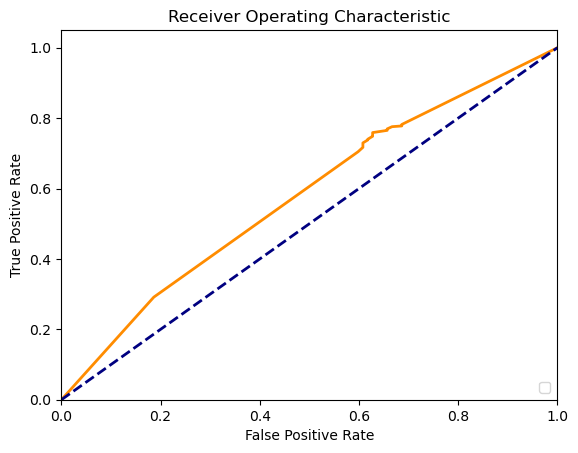

In [293]:
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color='darkorange', lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [294]:
print(roc_auc_score(Y_test, pos_prob))

0.5830250339129363


# Tuning models with cross-validation

In [295]:
from sklearn.model_selection import StratifiedKFold

In [296]:
k = 5

In [297]:
k_fold = StratifiedKFold(n_splits=k)

In [298]:
smoothing_factor_option = [1, 2, 3, 4, 5, 6]
fit_prior_option = [True, False]
auc_record = {}

In [299]:
for train_indices, test_indices in k_fold.split(X, Y):
    X_train, X_test = X[train_indices], X[test_indices]
    Y_train, Y_test = Y[train_indices], Y[test_indices]
    for alpha in smoothing_factor_option:
        if alpha not in auc_record:
            auc_record[alpha] = {}
        for fit_prior in fit_prior_option:
            clf = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
            clf.fit(X_train, Y_train)
            prediction_prob = clf.predict_proba(X_test)
            pos_prob = prediction_prob[:, 1]
            auc = roc_auc_score(Y_test, pos_prob)
            auc_record[alpha][fit_prior] = auc + auc_record[alpha].get(fit_prior, 0.0)

In [300]:
print('smoothing  fit prior  auc')

smoothing  fit prior  auc


In [301]:
for smoothing, smoothing_record in auc_record.items():
    for fit_prior, auc in smoothing_record.items():
        print(f'    {smoothing}        {fit_prior}    {auc/k:.5f}')

    1        True    0.59906
    1        False    0.59913
    2        True    0.60206
    2        False    0.60234
    3        True    0.60256
    3        False    0.60242
    4        True    0.60390
    4        False    0.60449
    5        True    0.60246
    5        False    0.60254
    6        True    0.60122
    6        False    0.60194


In [302]:
clf = MultinomialNB(alpha=2.0, fit_prior=False)
clf.fit(X_train, Y_train)

MultinomialNB(alpha=2.0, fit_prior=False)

In [303]:
pos_prob = clf.predict_proba(X_test)[:, 1]
print('AUC with the best model:', roc_auc_score(Y_test, pos_prob))

AUC with the best model: 0.5976359832635983
